<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/accelerating_chemical_mappings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping Chemical Space with UMAP (adapted from [blog post](https://blog.reverielabs.com/mapping-chemical-space-with-umap))

This notebook visualizes a chemical dataset describing Blood Brain Barrier Permeability (BBBP) from [MoleculeNet](http://moleculenet.ai/datasets-1) and [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t), then reduce those high-dimensional vectors down to 2 dimensions using conventional statistical tools. Ultimately we demonstrate how such an OPEN-SOURCE analysis can be sped-up and scaled-up massively with the [graphistry](graphistry.com) environment and toolkit


# Import accelerator libraries

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11 cudf-cu11 cugraph-cu11 pylibraft_cu11 raft_dask_cu11 dask_cudf_cu11 pylibcugraph_cu11 pylibraft_cu11
import cuml,cudf
print(cuml.__version__)

!pip install -U --force git+https://github.com/graphistry/pygraphistry.git@cudf
!pip install -U git+https://github.com/graphistry/cu-cat.git@DT
!pip install dirty_cat
!pip install umap-learn

In [2]:
print(cuml.__version__)

23.06.00


In [3]:
import graphistry
graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='fXjJnkE3Gik6BWy') ## key id, secret key

# graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='***') ## key id, secret key
print(graphistry.__version__)

import cu_cat
print(cu_cat.__file__)

import os
from collections import Counter
import cProfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pstats import Stats
import cudf
from time import time
import warnings
warnings.filterwarnings('ignore')
from typing import List
import seaborn as sns
pd.set_option('display.max_colwidth', 200)

0.28.7+463.gfb96400
/usr/local/lib/python3.10/dist-packages/cu_cat/__init__.py


In [5]:
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

Tesla T4


# Import Basics

In [ ]:
%%bash
# Install UMAP/hdbscan (recommend to do this before miniconda)
pip install --quiet umap-learn hdbscan rdkit
pip install --pre deepchem
# pip install tensorflow==2.2



In [11]:
from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import umap
import hdbscan

# Fingerprint functions

In [18]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """

    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)

    return None

In [ ]:
def plot_global_embeddings_with_clusters(df: pd.DataFrame,
                          x_col: str,
                          y_col: str,
                          cluster_col: str,
                          title: str = "",
                          x_lim = None,
                          y_lim = None):
    """ Plots data colored by soft HDBSCAN clusters

    If the cluster of a compund is not specified (cluster < 0), it will be
    plotted gray, otherwise it will be colored by the cluster value.
    """
    clustered = df[cluster_col].values >= 0

    plt.figure(figsize=(10,8))
    ax=sns.scatterplot(data=df.iloc[~clustered],
                    x=x_col,
                    y=y_col,
                    color=(0.5, 0.5, 0.5),
                    s=10,
                    alpha=0.1)
    sns.scatterplot(data=df.iloc[clustered],
                    x=x_col,
                    y=y_col,
                    hue=cluster_col,
                    alpha=0.5,
                    palette="nipy_spectral",
                    ax=ax)
    if x_lim:
      ax.set_xlim(x_lim)
    if y_lim:
      ax.set_ylim(y_lim)

    sm = plt.cm.ScalarMappable(cmap="nipy_spectral")
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Global Cluster")

    plt.title(title)
    plt.show()

# Embed BBBP with UMAP

### Read in and process small data

In [19]:
# Read in data from MoleculeNet
bbbp = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()
t=time()
# Compute descriptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]
print(time()-t)
print(bbbp.shape)

4.219825983047485
(2039, 3)


23.08222007751465


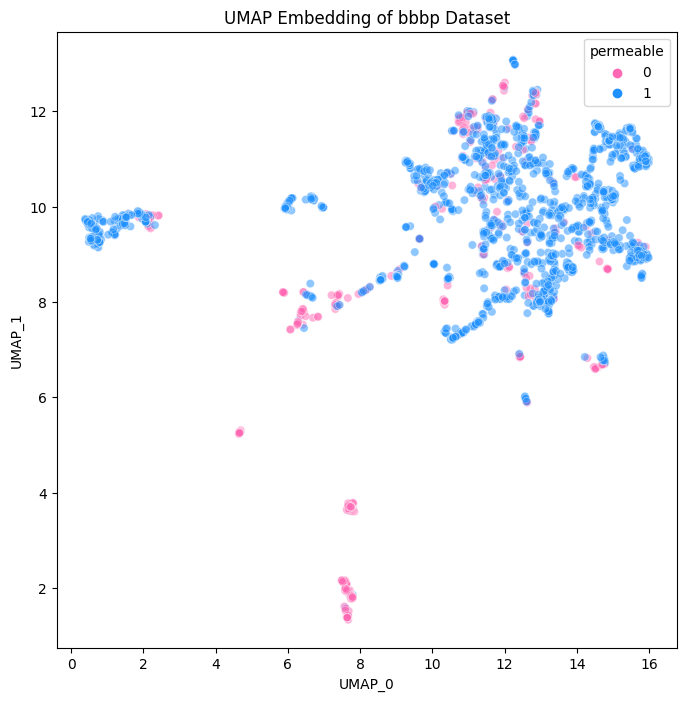

In [22]:
t=time()
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = X_umap[:,0], X_umap[:,1]
print(time()-t)
palette = sns.color_palette(["hotpink", "dodgerblue"])
for method in ["UMAP"]:
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5,
                    palette=palette)
    plt.title(f"{method} Embedding of bbbp Dataset")
    plt.show()


In [ ]:
3BBBP=bbbp[~bbbp.name.duplicated(keep='first')]
BBBP[['name','permeable']][BBBP.smiles.str.len()>3]#.reset_index(drop=True)

### ... and with graphistry

In [14]:
BBBP=bbbp[~bbbp.name.duplicated(keep='first')]

g = graphistry.nodes(cudf.from_pandas(BBBP[['smiles','permeable']][BBBP.smiles.str.len()>3]))
t=time()
# g2=g.featurize(feature_engine='cu_cat',memoize=True)
g3=g.umap(feature_engine='cu_cat',engine='cuml',metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
print("\n"+str(time()-t))

Using GPU: cu_cat



39.5584831237793


In [23]:
# g2.bind(node=BBBP.permeable) #[BBBP.smiles.str.len()>3])
g3.encode_point_color('permeable',palette=["hotpink", "dodgerblue"],as_continuous=True).plot()


## using a [universal fingerprint](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00445-4) rather than [morgan fingerprint from 1965](https://pubs.acs.org/doi/abs/10.1021/c160017a018)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install tmap
!pip install git+https://github.com/reymond-group/map4@v1.0


In [ ]:
# !pip install -q condacolab
# import condacolab
condacolab.install()

!conda install -c tmap tmap

In [ ]:
from rdkit import Chem
import tmap as tm
from map4 import MAP4Calculator

dim = 1024

MAP4 = MAP4Calculator(dimensions=dim)
ENC = tm.Minhash(dim)

smiles_a = 'c1ccccc1'
mol_a = Chem.MolFromSmiles(smiles_a)
map4_a = MAP4.calculate(mol_a)



### ... and with graphistry

In [ ]:
# PPB = PPB[PPB.columns.drop(list(PPB.filter(regex='UMAP')))]
g = graphistry.nodes(cudf.from_pandas(PPB[['smiles']][PPB.smiles.str.len()>3]))

t=time()
# g2=g.featurize(feature_engine='cu_cat',memoize=True)
g3=g.umap(feature_engine='cu_cat',engine='cuml',metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
print("\n"+str(time()-t))
emb2=g3._node_embedding
g222=graphistry.nodes(emb2.reset_index(),'index').edges(g3._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g222.plot()

## and larger data

In [24]:
PPB = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv")
t=time()
#Compute ECFP Descriptors
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(PPB["smiles"])
PPB = PPB.iloc[keep_idx]
print(PPB.shape)
print(time()-t)

(133885, 21)
272.26522612571716


173.70878624916077


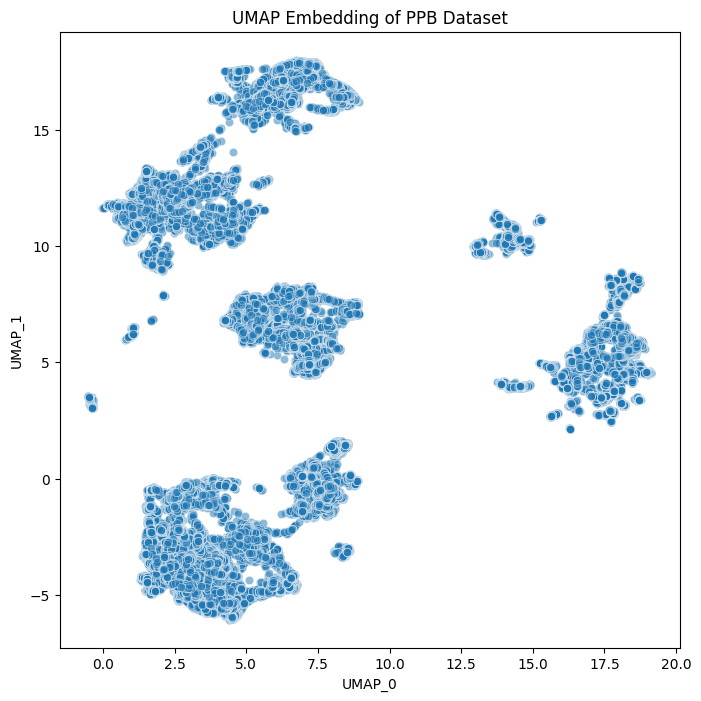

In [25]:
t=time()
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(ecfp_descriptors)
PPB["UMAP_0"], PPB["UMAP_1"] = X_umap[:,0], X_umap[:,1]
print(time()-t)
palette = sns.color_palette(["hotpink", "dodgerblue"])
for method in ["UMAP"]:
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=PPB,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    # hue="permeable",
                    alpha=0.5,
                    palette=palette)
    plt.title(f"{method} Embedding of PPB Dataset")
    plt.show()

### ... and with graphistry

In [26]:
# PPB = PPB[PPB.columns.drop(list(PPB.filter(regex='UMAP')))]
g = graphistry.nodes(cudf.from_pandas(PPB[['smiles']][PPB.smiles.str.len()>3]))
t=time()
# g2=g.featurize(feature_engine='cu_cat',memoize=True)
g3=g.umap(feature_engine='cu_cat',engine='cuml',metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)

print("\n"+str(time()-t))


Using GPU: cu_cat


483.4372627735138


In [27]:
emb2=g3._node_embedding
g222=graphistry.nodes(emb2.reset_index(),'index').edges(g3._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g222.plot()

# Embed BBBP in Global Chemical Space Approximation (Dataset-Agnostic Embedding)

### Read in and process ChEMBL data
_Note: We want this walk-through to be fully reproducible with publicly available data. Since the dataset we used at Reverie create our internal Dataset-Agnostic Embedding can't be shared here, instead we select a random sample of ChEMBL compounds as our approximation of global chemical space._

In [ ]:
# Read in data from MoleculeNet
chembl = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/chembl_sparse.csv.gz", compression='gzip')

# Sample a random 10k
chembl_sample = chembl.sample(n=10000)

### Compute ECFP descriptors

In [ ]:
%%time
# Compute desrciptors and keep track of which failed to featurize
chembl_ecfp_descriptors, chembl_keep_idx = compute_ecfp_descriptors(chembl_sample["smiles"])

# Only keep those that sucessfully featurized
chembl_sample = chembl_sample.iloc[chembl_keep_idx]

### Embed 'global' sample with UMAP to create Dataset-Agnostic model

In [ ]:
%%time
umap_model_global = umap.UMAP(metric = "jaccard",
                               n_neighbors = 25,
                               n_components = 2,
                               low_memory = False,
                               min_dist = 0.001)
X_umap_global = umap_model_global.fit_transform(chembl_ecfp_descriptors)
chembl_sample["UMAP_0"], chembl_sample["UMAP_1"] = X_umap_global[:,0], X_umap_global[:,1]

### Use Dataset-Agnostic UMAP model to embed BBBP

In [ ]:
%%time
X_umap_bbbp = umap_model_global.transform(ecfp_descriptors)
bbbp["UMAP_0 (global)"], bbbp["UMAP_1 (global)"] = X_umap_bbbp[:,0], X_umap_bbbp[:,1]

### Fit HDBScan clustering model on 'global' data & use to cluster BBBP

In [ ]:
# Define HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=10,
        min_samples=10,
        prediction_data=True,
        cluster_selection_method="eom")

# Fit and predict on ChEMBL-sample
chembl_sample["global_cluster"] = hdbscan_model.fit_predict(X_umap_global)

# Use ChEMBL-sample HDBSCAN model to cluster BBBP data
bbbp["global_cluster"], _ = hdbscan.approximate_predict(hdbscan_model, np.nan_to_num(X_umap_bbbp, nan=0))

### Visualize Dataset-Agnostic BBBP Embedding and Global Chemical Space Approximation (colored by global cluster)
* Because this is a soft clustering, some compounds don't end up getting assigned a cluster (their cluster value = 0)
* These compounds that do not end up in clusters are colored gray in these depictions
* With a larger 'global approximation' dataset than this 10k sample you are likely to have more compounds in the BBBP dataset that are represented by global clusters

In [ ]:
# Determine axes limits to put plots on the same scale
buffer_space = 0.5 # Extra space around the edges
x_lim = chembl_sample["UMAP_0"].min()-buffer_space, chembl_sample["UMAP_0"].max()+buffer_space
y_lim = chembl_sample["UMAP_1"].min()-buffer_space, chembl_sample["UMAP_1"].max()+buffer_space

In [ ]:
plot_global_embeddings_with_clusters(bbbp,
                      x_col="UMAP_0 (global)",
                      y_col="UMAP_1 (global)",
                      x_lim=x_lim,
                      y_lim=y_lim,
                      cluster_col="global_cluster",
                      title="Dataset-Agnostic Embedding of BBBP Dataset")

plot_global_embeddings_with_clusters(chembl_sample,
                      x_col="UMAP_0",
                      y_col="UMAP_1",
                      x_lim=x_lim,
                      y_lim=y_lim,
                      cluster_col="global_cluster",
                      title="Global Chemical Space Embedding")